In [1]:
%pip install pandas matplotlib scipy seaborn ipyfilechooser

Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz

In [10]:
from scipy.signal import savgol_filter

from common import combine_csvs
import common

In [102]:
MEGAb_TO_b = 1e6
TCP_DOWN = 'TCP Down'
UDP_DOWN = 'UDP Down'
TCP_UP = 'TCP Up'
UDP_UP = 'UDP Up'
PROTOCOLS_MAP = {TCP_DOWN: "*down.*.csv", UDP_DOWN: "*down*udp*.csv", 
                 TCP_UP: "*up.*[!p].csv", UDP_UP: "*receive*.udp.csv"}

TEMP='Temp (°C)'
PRECIP='Precip. Amount (mm)'

JITTER = 'jitter_ms'
BANDWIDTH = 'bandwidth'

N_STARLINK = 'Starlink'
N_HOME = 'Home'

N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_PROTOCOL = 'Protocol'

OUTPUT_FOLDER = 'output/throughput'

In [12]:
plot_params = common.plot_params
plot_params['figure.figsize'] = (7.16, 4)
plot_params['figure.dpi'] = 300
matplotlib.rcParams.update()

sns_params = common.sns_params
sns_params['figure.figsize'] = (7.16, 4)
sns_params['figure.dpi'] = 300
sns.set_context("paper", rc=sns_params)

In [13]:
def convert_to_mb(df):
    # Converts to Megabits per second
    df.bits_per_second /= MEGAb_TO_b
    df.rename(columns={'bits_per_second': 'bandwidth'}, inplace=True)

In [14]:
def concat_df(src, pattern, keep=['bandwidth']):
    files = glob.glob(f"{src}/**/{pattern}", recursive=True)
    combined_df = combine_csvs(files)
    
    combined_df.index = pd.to_datetime(combined_df.index, unit='s')
    if keep == ['bandwidth']:
        convert_to_mb(combined_df)
    combined_df = combined_df[keep]
    return combined_df

In [15]:
def remove_first_measures(df, first=3):
    # Remove first {first} datapoints for each measurement
    # Take into account of software tool overhead
    diff_time = (df.index - df.reset_index().timestamp.shift())
    # Choose entries where previous time is less than an hour
    first_measure_map = diff_time < pd.Timedelta(5, unit='m')
    # Propagate to first three datapoints
    for i in range(1, first):
        first_measure_map = first_measure_map.eq(first_measure_map.shift(i))

    df_map = pd.DataFrame(columns=df.columns)
    df_map.iloc[:,0] = first_measure_map
    df_map['timestamp'] = df.index
    df_map.set_index('timestamp', inplace=True)
    filtered_df = df.where(df_map, -1) # Set to -1

    return filtered_df

In [16]:
def combine_reg_old(src, pattern, keep=['bandwidth'], first=3):
    regions_df = pd.DataFrame()
    start = True
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, keep).sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df.rename(columns={keep: reg_name}, inplace=True)
        combined_df = remove_first_measures(combined_df, first)

        if start:
            regions_df = combined_df
            start = False
        else:
            regions_df = pd.merge(regions_df, combined_df, how='outer', left_index=True, right_index=True)

    return regions_df

In [97]:
def combine_reg(src, pattern, keep=['bandwidth'], first=3):
    regions_df = pd.DataFrame()
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, keep).sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df = remove_first_measures(combined_df, first)
        combined_df[N_REGIONS] = common.region_mapping[reg_name]

        if regions_df.empty:
            regions_df = combined_df
        else:
            regions_df = pd.concat([regions_df, combined_df])

    return regions_df


In [116]:
src_dirs = []
src_dirs += [('Home', 'data/Home_network_data/Iperf_csv/2022-01-19_trad_iperf/')]
src_dirs += [('Starlink', 'data/starlink-data/Iperf_csv/2022-01-23_starlink_iperf_tcp/')]

src_dirs += [('Home', 'data/Home_network_data/Iperf_csv/2022-03-23_trad_iperf/')]
src_dirs += [('Starlink', 'data/starlink-data/Iperf_csv/2022-03-21_starlink_iperf/')]

src_dirs += [('Home', 'data/Home_network_data/Iperf_csv/2022-04-09-traditional_measures/')]
src_dirs += [('Starlink', 'data/starlink-data/Iperf_csv/2022-04-09_starlink_iperf/')]

src_dirs += [('Home', 'data/Home_network_data/Iperf_csv/2022-04-12_trad_iperf_rain/')]
src_dirs += [('Starlink', 'data/starlink-data/Iperf_csv/2022-04-26_starlink_iperf/')]

src_dirs += [('Home', 'data/Home_network_data/Iperf_csv/2022-05-27_traditional_measures_throughput/')]
src_dirs += [('Home', 'data/Home_network_data/Iperf_csv/2022-05-28_traditional_measures_throughput/')]
src_dirs += [('Starlink', 'data/starlink-data/Iperf_csv/2022-05-19_starlink_iperf/')]

src_dirs += [('Home', 'data/Home_network_data/Iperf_csv/2022-06-03_traditional_measures_throughput/')]
src_dirs += [('Starlink', 'data/starlink-data/Iperf_csv/2022-06-03_starlink_throughput_measurements/')]
src_dirs

[('Home', 'data/Home_network_data/Iperf_csv/2022-01-19_trad_iperf/'),
 ('Starlink', 'data/starlink-data/Iperf_csv/2022-01-23_starlink_iperf_tcp/'),
 ('Home', 'data/Home_network_data/Iperf_csv/2022-03-23_trad_iperf/'),
 ('Starlink', 'data/starlink-data/Iperf_csv/2022-03-21_starlink_iperf/'),
 ('Home', 'data/Home_network_data/Iperf_csv/2022-04-09-traditional_measures/'),
 ('Starlink', 'data/starlink-data/Iperf_csv/2022-04-09_starlink_iperf/'),
 ('Home', 'data/Home_network_data/Iperf_csv/2022-04-12_trad_iperf_rain/'),
 ('Starlink', 'data/starlink-data/Iperf_csv/2022-04-26_starlink_iperf/'),
 ('Home',
  'data/Home_network_data/Iperf_csv/2022-05-27_traditional_measures_throughput/'),
 ('Home',
  'data/Home_network_data/Iperf_csv/2022-05-28_traditional_measures_throughput/'),
 ('Starlink', 'data/starlink-data/Iperf_csv/2022-05-19_starlink_iperf/'),
 ('Home',
  'data/Home_network_data/Iperf_csv/2022-06-03_traditional_measures_throughput/'),
 ('Starlink',
  'data/starlink-data/Iperf_csv/2022-0

In [117]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    for (protocol, pattern) in PROTOCOLS_MAP.items():
        #df = concat_df(args.src_folder, UDP_UP, [JITTER])
        try:
            df_temp = combine_reg(folder, pattern, first=3)
        except:
            print(f'Error getting {protocol}: {folder}')
            continue
        
        df_temp[N_PROTOCOL] = protocol
        df_temp[N_TYPE] = type_name
        if not df.empty:
            #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
        
df

Error getting UDP Down: data/Home_network_data/Iperf_csv/2022-01-19_trad_iperf/
Error getting UDP Up: data/Home_network_data/Iperf_csv/2022-01-19_trad_iperf/
Error getting UDP Down: data/starlink-data/Iperf_csv/2022-01-23_starlink_iperf_tcp/
Error getting UDP Up: data/starlink-data/Iperf_csv/2022-01-23_starlink_iperf_tcp/
Error getting TCP Down: data/Home_network_data/Iperf_csv/2022-03-23_trad_iperf/
Error getting TCP Up: data/Home_network_data/Iperf_csv/2022-03-23_trad_iperf/
Error getting TCP Down: data/starlink-data/Iperf_csv/2022-03-21_starlink_iperf/
Error getting TCP Up: data/starlink-data/Iperf_csv/2022-03-21_starlink_iperf/
Error getting TCP Down: data/Home_network_data/Iperf_csv/2022-04-09-traditional_measures/
Error getting TCP Up: data/Home_network_data/Iperf_csv/2022-04-09-traditional_measures/
Error getting TCP Down: data/starlink-data/Iperf_csv/2022-04-09_starlink_iperf/
Error getting TCP Up: data/starlink-data/Iperf_csv/2022-04-09_starlink_iperf/
Error getting TCP Down: 

,bandwidth,Regions,Protocol,Type
timestamp,,,,
2022-01-19 01:55:20.000000000,-1.000000,Sydney,TCP Down,Home
2022-01-19 01:55:21.000137984,-1.000000,Sydney,TCP Down,Home
2022-01-19 01:55:22.000154112,-1.000000,Sydney,TCP Down,Home
2022-01-19 01:55:23.000016896,-1.000000,Sydney,TCP Down,Home
2022-01-19 01:55:24.000022016,148.455179,Sydney,TCP Down,Home
...,...,...,...,...
2022-06-05 05:07:08.000074752,9.348297,Mumbai,UDP Up,Starlink
2022-06-05 05:07:09.000073984,9.069528,Mumbai,UDP Up,Starlink
2022-06-05 05:07:10.000155904,4.645561,Mumbai,UDP Up,Starlink


In [118]:
df_regs = df.replace(-1, pd.NA)
#df_regs = df_regs.astype(object).where(df_regs.notnull(), None)
df_regs = df_regs.dropna().astype({'bandwidth': float})
df_regs = df_regs.sort_values(N_PROTOCOL)
#df = concat_df(args.src_folder, UDP_DOWN).sort_values('timestamp')

print(df_regs.dtypes)
df_regs

bandwidth    float64
Regions       object
Protocol      object
Type          object
dtype: object


,bandwidth,Regions,Protocol,Type
timestamp,,,,
2022-01-19 01:55:24.000022016,148.455179,Sydney,TCP Down,Home
2022-01-23 06:42:50.000112128,46.903616,London,TCP Down,Starlink
2022-01-23 06:42:51.000112128,61.001402,London,TCP Down,Starlink
2022-01-23 06:42:52.000111104,63.874435,London,TCP Down,Starlink
2022-01-23 06:42:53.000107008,63.422143,London,TCP Down,Starlink
...,...,...,...,...
2022-05-29 12:04:50.000017920,108.595003,Tokyo,UDP Up,Home
2022-05-29 12:04:51.000064000,108.669504,Tokyo,UDP Up,Home
2022-05-29 12:04:52.000064000,108.321545,Tokyo,UDP Up,Home


In [169]:
df_outage = df_regs.fillna(-1)
df_outage = df_outage[df_outage == 0].dropna(how='all')
df_outage = df_outage.unstack().dropna(how=all)
df_outage = df_unstacked.reset_index(drop=True)
df_outage.rename(columns={'level_0': N_TYPE, 'level_1': N_REGIONS},
        inplace=True)
df_outage

,Type,Regions,timestamp,bandwidth
0,Starlink,South_America_Sao_Paulo,2022-06-03 10:18:00,11.126501
1,Starlink,South_America_Sao_Paulo,2022-06-03 10:19:00,11.114772
2,Starlink,South_America_Sao_Paulo,2022-06-03 10:20:00,11.103042
3,Starlink,South_America_Sao_Paulo,2022-06-03 10:21:00,11.091313
4,Starlink,South_America_Sao_Paulo,2022-06-03 10:22:00,11.079583
...,...,...,...,...
36531,Home,Asia_Pacific_Mumbai,2022-06-05 05:11:00,109.007887
36532,Home,Asia_Pacific_Mumbai,2022-06-05 05:12:00,109.007887
36533,Home,Asia_Pacific_Mumbai,2022-06-05 05:13:00,109.007887
36534,Home,Asia_Pacific_Mumbai,2022-06-05 05:14:00,109.007887


In [ ]:
# Aggreagation options
#df_regs = df_regs.loc['2022-06':]
#df = df.loc['2022-03-01 04:07:30':'2022-03-01 04:08:40']
#df = df.loc['2022-03-01':'2022-03-02']
df_regs_interp = df_regs.groupby([N_TYPE, N_REGIONS, N_PROTOCOL])
df_regs_interp = df_regs_interp.resample('H').mean()
#df_regs_interp = df_regs_interp.interpolate(method='linear')
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,21,1))
df_unstacked = df_regs_interp.reset_index().dropna()
# Perform savgol filtering
df_unstacked

#df.to_csv("out.csv", encoding='utf-8-sig')


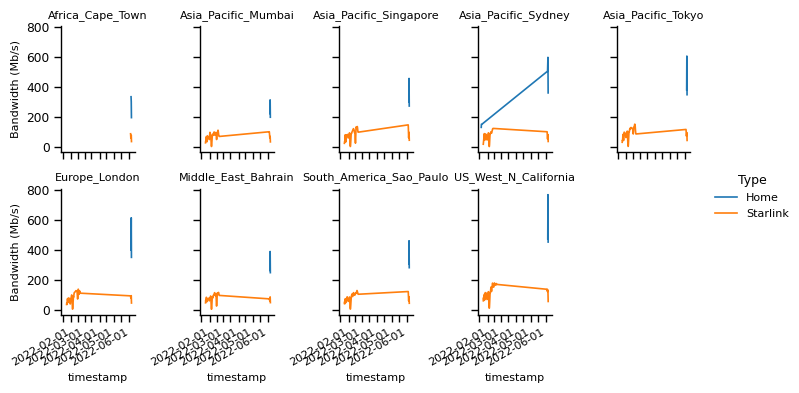

In [81]:
#fig, ax = plt.subplots(figsize=(3.5,3))
#fig, ax = plt.subplots(figsize=(20,10))

#ax.xaxis.update_units(df.index)
#y_val = df_unstacked.bandwidth
#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

df_filt = df_unstacked[df_unstacked[N_PROTOCOL] == TCP_DOWN]
g = sns.FacetGrid(data=df_filt, col=N_REGIONS, hue=N_TYPE, 
                  height=2, aspect=0.716, col_wrap=5)
g.map(sns.lineplot, 'timestamp', 'bandwidth')

#g_ax = g.fig.axes
#sns.scatterplot(data=df_outage, ax=g_ax)


#g = sns.lineplot(data=df_unstacked, x='timestamp', y='bandwidth', hue=N_REGIONS, style=N_TYPE)
#g = sns.lineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')

g.figure.autofmt_xdate()
for ax in g.axes.flat:
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)
    tick_locs = ax.get_xticks()

#ax.set_ylabel("Jitter (ms)")
g.add_legend()
g.set_titles(col_template="{col_name}")
g.set(ylabel="Bandwidth (Mb/s)")
g.tight_layout()
#fig.tight_layout()

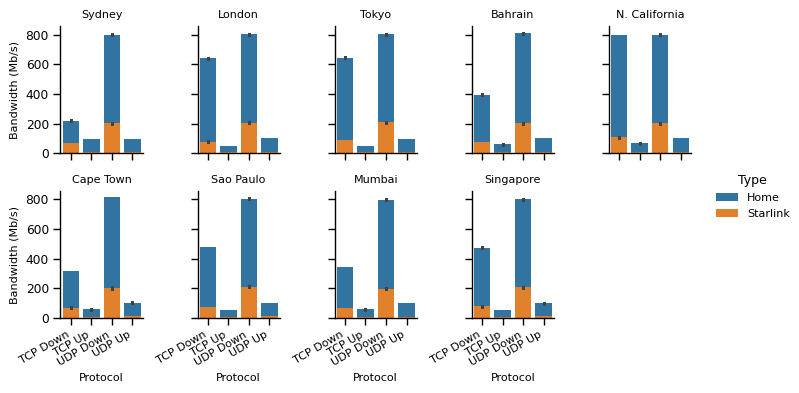

In [137]:
g_bar = sns.FacetGrid(data=df_regs, col=N_REGIONS, hue=N_TYPE, 
                  height=2, aspect=0.716, col_wrap=5)
g_bar.map_dataframe(sns.barplot, x=N_PROTOCOL, y='bandwidth')

g_bar.figure.autofmt_xdate()
g_bar.add_legend()
g_bar.set_titles(col_template="{col_name}")
g_bar.set(ylabel="Bandwidth (Mb/s)")
g_bar.tight_layout()

In [1]:
g_bar.savefig(os.path.join(OUTPUT_FOLDER, 'throughput_summary.pgf'), bbox_inches='tight')

NameError: name 'g_bar' is not defined

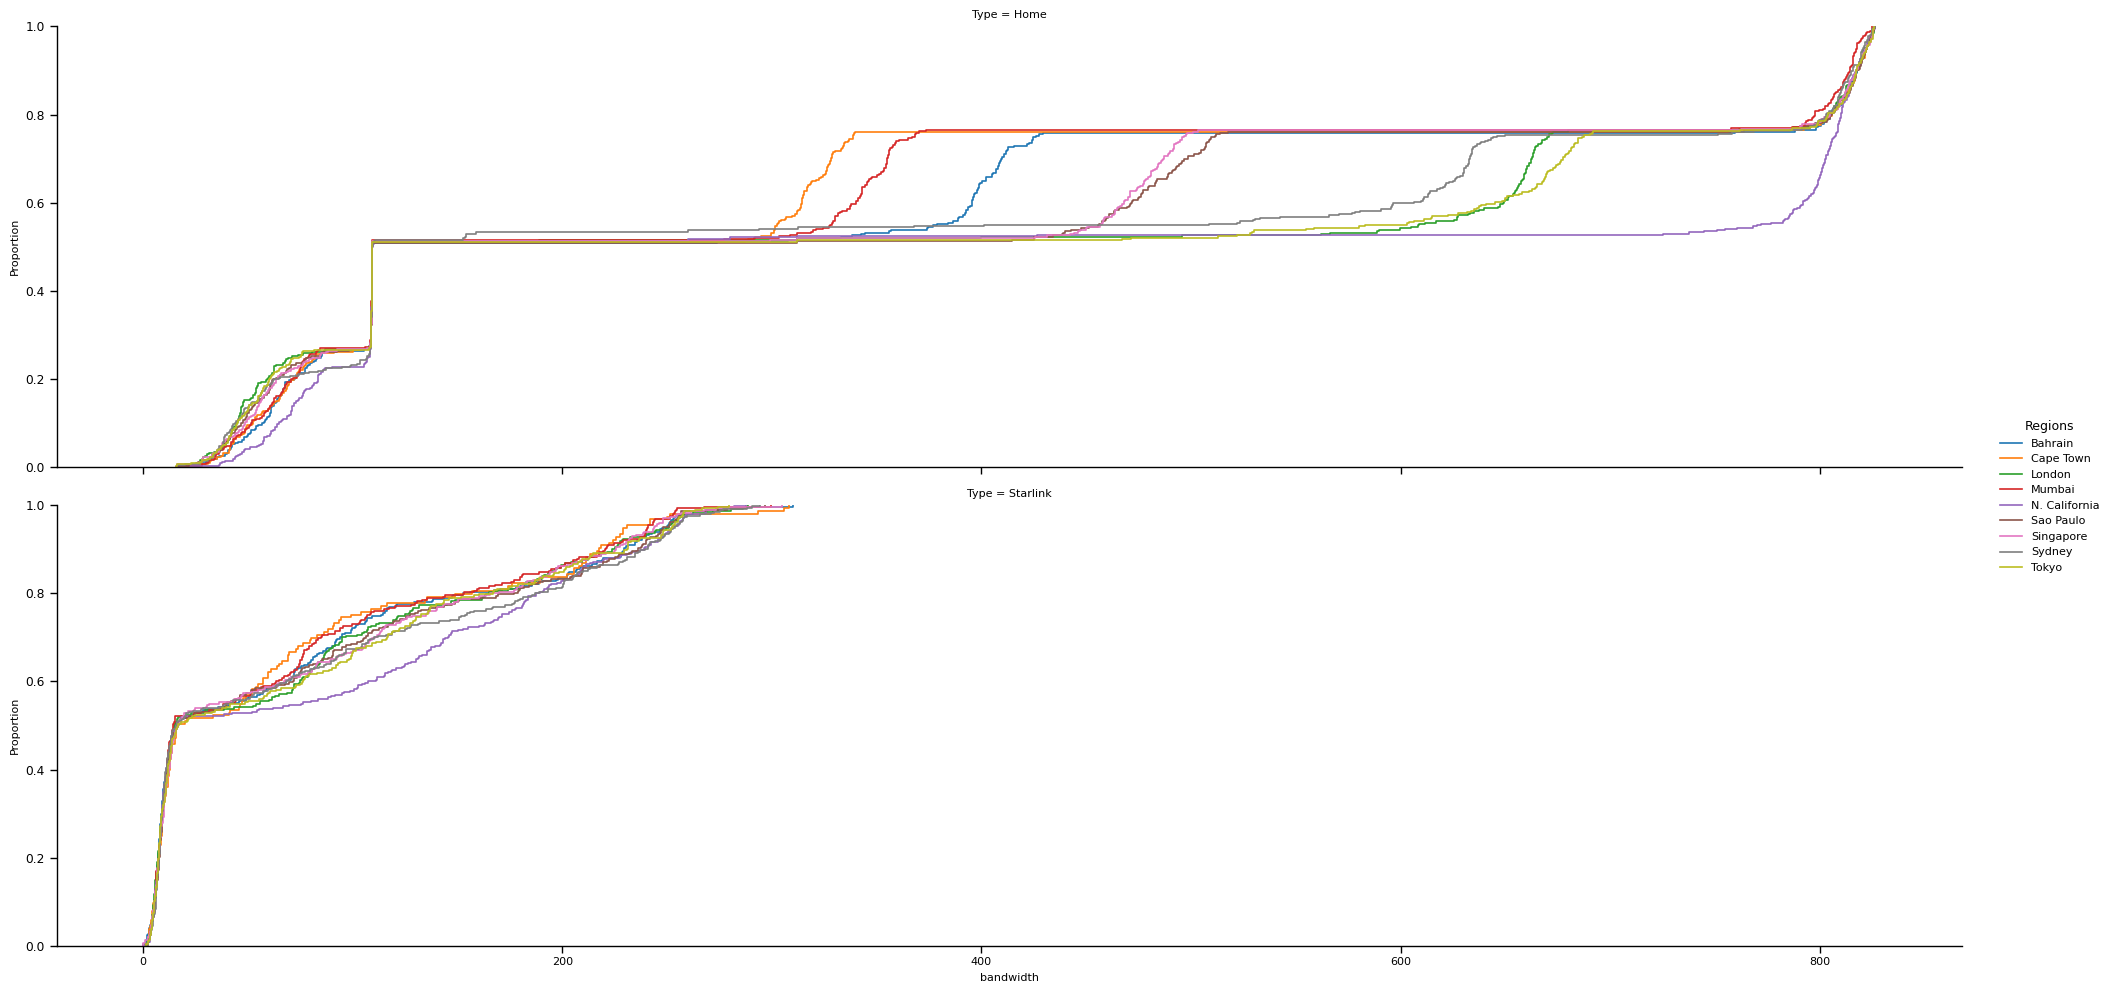

In [135]:
#fig2, ax2 = plt.subplots(figsize=(20,10))
g2 = sns.FacetGrid(data=df_unstacked, row=N_TYPE, hue=N_REGIONS, height=5, aspect=4)
g2.map(sns.ecdfplot, 'bandwidth')
g2.add_legend()
g2.tight_layout()
#fig2.tight_layout()

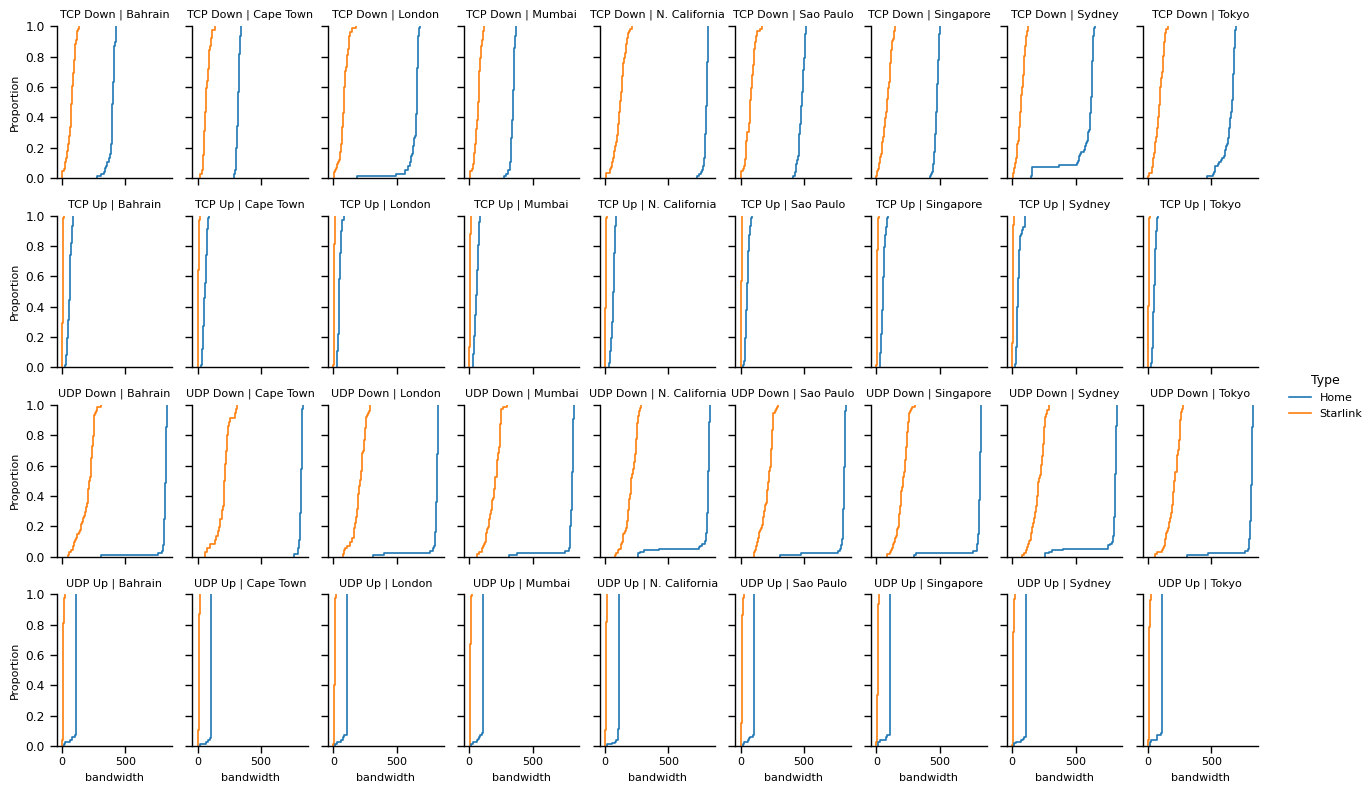

In [136]:
g_hist = sns.displot(
    data=df_unstacked, 
    x='bandwidth', col=N_REGIONS, row=N_PROTOCOL, hue=N_TYPE, kind='ecdf', height=2, aspect=0.716)
g_hist.set_titles(col_template="{col_name}", row_template="{row_name}")
g_hist.tight_layout()

In [150]:
g.savefig(f'output/throughput/throughput.pdf', bbox_inches='tight')
g2.savefig(f'output/throughput/throughput_cdf.pdf', bbox_inches='tight')
#fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
#fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')